# Analyse exploratoire du dataset Vinho Verde

**Contexte**  
Ce notebook constitue la première étape de notre étude sur le jeu de données « Vinho Verde » (vins rouges portugais) issu de l’étude Cortez et al. Trois évaluateurs du CRVV ont noté chaque échantillon sur une échelle de 0 à 10. L’objectif principal est d’explorer les variables physico-chimiques pour préparer les futures modélisations supervisées (régression et classification).

**Retours du professeur**  
- Définir clairement l’« histoire » que l’on racontera lors de la soutenance :  
  1. **Comment les propriétés chimiques influencent la qualité perçue ?**  
  2. **Quelles seraient les caractéristiques d’un vin « excellent » ?**  
  3. **Comment prédire la qualité numérique (régression) ?**  
  4. **Comment classer un vin en « bon » vs « mauvais » (classification binaire) ?**  
- La variable `quality` est discrète (0–10) : on peut l’aborder en régression (valeur continue ordinale) ou la transformer en variable binaire/qualitative pour la classification (ex. `quality ≥ 6`).

**Objectifs de ce notebook**  
1. Charger et typer le dataset  
2. Nettoyer, dédupliquer et normaliser les variables  
3. Réaliser une EDA univariée et bivariée (corrélations, visualisations, interprétations mathématiques et statistiques)  
4. Clarifier le choix entre régression et classification  
5. Structurer le workflow pour les prochains notebooks

**Plan du notebook**  
1. **Préambule et imports**  
2. **Chargement & typage des données**  
3. **Nettoyage & pré-traitement**  
4. **Analyse exploratoire (EDA)**  
5. **Dimensionnement du problème**  
6. **Synthèse & prochaines étapes**


## 0 - Installation des librairies
---
Au cours de ce notebook, nous utilisons différentes fonctions ou classes venant de librairies non implémentées directement dans Python. Pour le bon fonctionnement de l'ensemble des cellules présentant du code, les importations ci-dessous sont nécessaires.

In [1]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram
from pandas import DataFrame, Index
from typing import List
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

os.environ["LOKY_MAX_CPU_COUNT"] = "8"

## 1 - Généralités sur les variables
---

Dans cette section, nous identifions les variables quantitatives et qualitatives présentes dans le jeu de données. Cela nous permet de mieux comprendre la structure des données et de planifier les étapes suivantes de l'analyse.

### a. Chargement des données

Ce jeu de données est lié aux variantes rouges du vin portugais \"Vinho Verde\". Il décrit la quantité de divers composés chimiques présents dans le vin ainsi que sa qualité. 

#### Lien vers le dataset :
[Wine Quality Dataset (Kaggle)](https://www.kaggle.com/datasets/yasserh/wine-quality-dataset?select=WineQT.csv)

In [2]:
# Chargement des données
path: str = os.path.join(os.path.dirname(os.getcwd()), "data", "WineQT.csv")
data: pd.DataFrame = pd.read_csv(path, index_col="Id")

### b. Aperçu du jeu de données

In [3]:
# Informations générales
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1143 entries, 0 to 1597
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1143 non-null   float64
 1   volatile acidity      1143 non-null   float64
 2   citric acid           1143 non-null   float64
 3   residual sugar        1143 non-null   float64
 4   chlorides             1143 non-null   float64
 5   free sulfur dioxide   1143 non-null   float64
 6   total sulfur dioxide  1143 non-null   float64
 7   density               1143 non-null   float64
 8   pH                    1143 non-null   float64
 9   sulphates             1143 non-null   float64
 10  alcohol               1143 non-null   float64
 11  quality               1143 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 116.1 KB


In [4]:
# Aperçu des données
data.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
Id                                                                            
0             7.4              0.70         0.00             1.9      0.076   
1             7.8              0.88         0.00             2.6      0.098   
2             7.8              0.76         0.04             2.3      0.092   
3            11.2              0.28         0.56             1.9      0.075   
4             7.4              0.70         0.00             1.9      0.076   

    free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
Id                                                                        
0                  11.0                  34.0   0.9978  3.51       0.56   
1                  25.0                  67.0   0.9968  3.20       0.68   
2                  15.0                  54.0   0.9970  3.26       0.65   
3                  17.0                  60.0   0.9980  3.16       0.58   
4                  11.0                  34.0   0.9978  3.51       0.56   

    alcohol  quality  
Id                    
0       9.4        5  
1       9.8        5  
2       9.8        5  
3       9.8        6  
4       9.4        5

In [5]:
# Statistiques descriptives
data.describe()

fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1143.000000       1143.000000  1143.000000     1143.000000   
mean        8.311111          0.531339     0.268364        2.532152   
std         1.747595          0.179633     0.196686        1.355917   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.392500     0.090000        1.900000   
50%         7.900000          0.520000     0.250000        2.200000   
75%         9.100000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1143.000000          1143.000000           1143.000000  1143.000000   
mean      0.086933            15.615486             45.914698     0.996730   
std       0.047267            10.250486             32.782130     0.001925   
min       0.012000             1.000000              6.000000     0.990070   
25%       0.070000             7.000000             21.000000     0.995570   
50%       0.079000            13.000000             37.000000     0.996680   
75%       0.090000            21.000000             61.000000     0.997845   
max       0.611000            68.000000            289.000000     1.003690   

                pH    sulphates      alcohol      quality  
count  1143.000000  1143.000000  1143.000000  1143.000000  
mean      3.311015     0.657708    10.442111     5.657043  
std       0.156664     0.170399     1.082196     0.805824  
min       2.740000     0.330000     8.400000     3.000000  
25%       3.205000     0.550000     9.500000     5.000000  
50%       3.310000     0.620000    10.200000     6.000000  
75%       3.400000     0.730000    11.100000     6.000000  
max       4.010000     2.000000    14.900000     8.000000

Ce jeu de données comporte 1143 individus (ici des vins rouges) décrits par 12 variables. Une treizième variable existe, mais représente les ID des vins, cela représentera donc l'index des individus.

### c. Types des variables et signification

In [6]:
# Types de variables
quantitative_vars: list[str] = data.select_dtypes(
    include=["float64", "int64"]
).columns.tolist()
print("Variables quantitatives :", quantitative_vars)
qualitative_vars: list[str] = data.select_dtypes(
    include=["object"]).columns.tolist()
print("Variables qualitatives :", qualitative_vars)

Variables quantitatives : ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']
Variables qualitatives : []


Dans ce dataset, nous avons uniquement des variables quantitatives. Cela représente un avantage, puisque la grande majorité des analyses de données sont prévues pour de telles variables (PCA, Classification, ...)

## 2 - Compréhension des variables
---

Dans cette section, nous présentons d'abord les attributs mesurés sur nos individus, ainsi que les propriétés chimiques du vin.  
Puis, nous étudions la corrélation entre les variables ainsi que la répartition de valeurs de certaines d'entre elles.  
Cela nous permet, dans un premier temps, de mieux comprendre le secteur viticole et donc nos variables, d'identifier les potentielles valeurs aberrantes et enfin d'être capable de bien décrire notre jeu de données.  

### a. Signification des différentes variables 

The 14 attributes are described as follows:

- **fixed acidity:** Acids are one of the fundamental properties of wine and contribute greatly to the taste of the wine. Reducing acids significantly might lead to wines tasting flat. Fixed acids include tartaric, malic, citric, and succinic acids which are found in grapes (except succinic). This variable is usually expressed in $\frac{g(tartaricacid)}{dm^3}$ in the dataset.


- **volatile acidity:** These acids are to be distilled out from the wine before completing the production process. It is primarily constituted of acetic acid though other acids like lactic, formic and butyric acids might also be present. Excess of volatile acids are undesirable and lead to unpleasant flavor. In the US, the legal limits of volatile acidity are 1.2 g/L for red table wine and 1.1 g/L for white table wine. The volatile acidity is expressed in $\frac{g(aceticacid)}{dm^3}$ in the dataset.


- **citric acid:** This is one of the fixed acids which gives a wine its freshness. Usually most of it is consumed during the fermentation process and sometimes it is added separately to give the wine more freshness. It's usually expressed in $\frac{g}{dm^3}$ in the dataset.


- **residual sugar:** This typically refers to the natural sugar from grapes which remains after the fermentation process stops, or is stopped. It's usually expressed in $\frac{g}{dm^3}$ in the dataset.


- **chlorides:** This is usually a major contributor to saltiness in wine. It's usually expressed in $\frac{g(sodiumchloride)}{dm^3}$ in the dataset.


- **free sulfur dioxide:** This is the part of the sulphur dioxide that when added to a wine is said to be free after the remaining part binds. Winemakers will always try to get the highest proportion of free sulphur to bind. They are also known as sulfites and too much of it is undesirable and gives a pungent odour. This variable is expressed in $\frac{mg}{dm^3}$ in the dataset.


- **total sulfur dioxide:** This is the sum total of the bound and the free sulfur dioxide ($SO_2$). Here, it's expressed in $\frac{mg}{dm^3}$. This is mainly added to kill harmful bacteria and preserve quality and freshness. There are usually legal limits for sulfur levels in wines and excess of it can even kill good yeast and give out undesirable odour.


- **density:** This can be represented as a comparison of the weight of a specific volume of wine to an equivalent volume of water. It is generally used as a measure of the conversion of sugar to alcohol. Here, it's expressed in $\frac{g}{cm^3}$.


- **pH:** Also known as the potential of hydrogen, this is a numeric scale to specify the acidity or basicity the wine. Fixed acidity contributes the most towards the pH of wines. You might know, solutions with a pH less than 7 are acidic, while solutions with a pH greater than 7 are basic. With a pH of 7, pure water is neutral. Most wines have a pH between 2.9 and 3.9 and are therefore acidic.


- **sulphates:** These are mineral salts containing sulfur. Sulphates are to wine as gluten is to food. They are a regular part of the winemaking around the world and are considered essential. They are connected to the fermentation process and affects the wine aroma and flavor. Here, it's expressed in $\frac{g(potassiumsulphate)}{dm^3}$ in the dataset.


- **alcohol:** Wine is an alcoholic beverage. Alcohol is formed as a result of yeast converting sugar during the fermentation process. The percentage of alcohol can vary from wine to wine. Hence it is not a surprise for this attribute to be a part of this dataset. It's usually measured in % vol or alcohol by volume (ABV).


- **quality:** Wine experts graded the wine quality between 0 (very bad) and 10 (very excellent). The eventual quality score is the median of at least three evaluations made by the same wine experts.


- **wine_type:** Since we originally had two datasets for red and white wine, we introduced this attribute in the final merged dataset which indicates the type of wine for each data point. A wine can either be a 'red' or a 'white' wine. One of the predictive models we will build in this chapter would be such that we can predict the type of wine by looking at other wine attributes.


- **quality_label:** This is a derived attribute from the `quality` attribute. We bucket or group wine quality scores into three qualitative buckets namely low, medium and high. Wines with a quality score of 3, 4 & 5 are low quality, scores of 6 & 7 are medium quality and scores of 8 & 9 are high quality wines. We will also build another model in this chapter to predict this wine quality label based on other wine attributes. 

### b. Quelques éléments de contexte

Le *vinho verde* (vin vert) est un vin portuguais. Cette appellation ne vient pas de la couleur du vin mais de son mode de production, c'est-à-dire la manière dont sont cultivées les vignes. En effet, les raisins sont récoltés avant d'être complètement mûrs. On peut parler de vin jeune. Le vinho verde existe sous forme de vin blanc, vin rouge ou même rosé.  
  
Notre jeu de données présente les individus comme des __vins rouges__.  
Nous allons tenter ici de vérifier et valider cette caractéristique à l'aide de recherches sur les différences de propriétés chimiques en fonction de la couleur du vin ainsi qu'aux données de référence sur le sujet : *[Cortez et al., 2009], http://www3.dsi.uminho.pt/pcortez/wine/*. Ces informations ont été sélectionnées pour être adaptées à notre sujet, c'est-à-dire ici dans le cas de vins portuguais *vinho verde* (dont les raisins sont cueilllis avant maturité).  
La littérature présente des différences de caractéristiques chimiques en fonction de la couleur du vin dans le cadre d'une production de *vinho verde*.  
En effet un vin blanc est plutôt caractérisé par : 
- un pH autour de 3,0 et 3,2
- un taux de sucre résiduel entre 6 et 7 g/L
- une acidité volatile basse 0,25 et 0,30 g/L

Alors qu'un __vin rouge__ est davantage marqué par :  
- un pH autour de 3,3 et 3,5 (plus élevé)  
- un taux de sucre résiduel moyen entre 2 et 3 g/L (plus faible)  
- une acidité volatile d'environ 0,50 g/L (plus élevé)  
  
Une première visualisation est réalisée avec les individus de notre jeu de données en fonction des trois caractéristiques qui marquent des différences en fonction de la couleur du vin.
Dans un second temps, nous pouvons tenter de comparer les données à celles de référence sur le sujet.
L'ensemble nous permet de caractériser avec confiance la couleur du vin des individus.



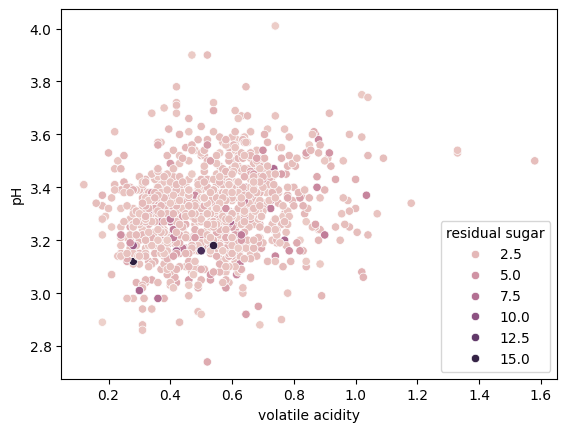

In [7]:
# sns.scatterplot(x="pH", y="volatile acidity", data=data)
sns.scatterplot(x="volatile acidity", y="pH", hue="residual sugar", data=data)
plt.show()

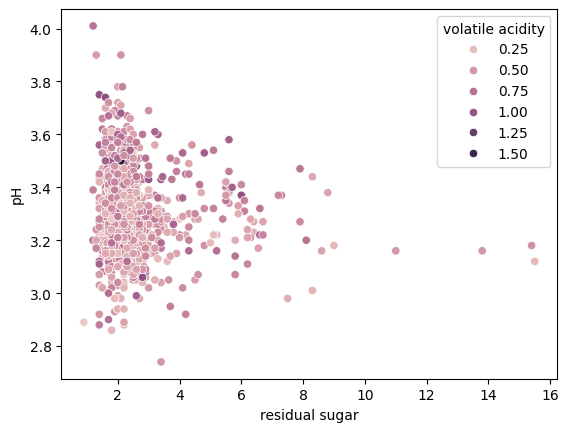

In [8]:
# sns.scatterplot(x="pH", y="residual sugar", data=data)
sns.scatterplot(x="residual sugar", y="pH", hue="volatile acidity", data=data)
plt.show()

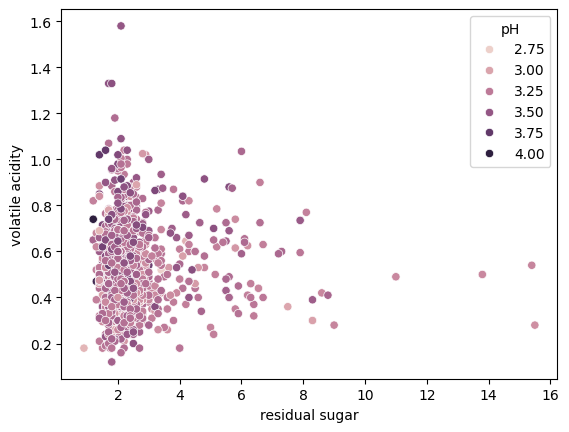

In [9]:
# sns.scatterplot(x="volatile acidity", y="residual sugar", data=data)
sns.scatterplot(x="residual sugar", y="volatile acidity", hue="pH", data=data)
plt.show()

### c. Liens entre les variables

Le *diagramme de corrélation* est utile pour voir les liens de type linéaires entre variables quantitatives. 
Nous n'avons pas enlevé ici la qualité jugée du vin car il est tout de même intéressant de voir s'il existe un lien assez direct avec un ou plusieurs autres variables (même si ce serait le signe d'un travail trop simple et rapide sur ce jeu de données).

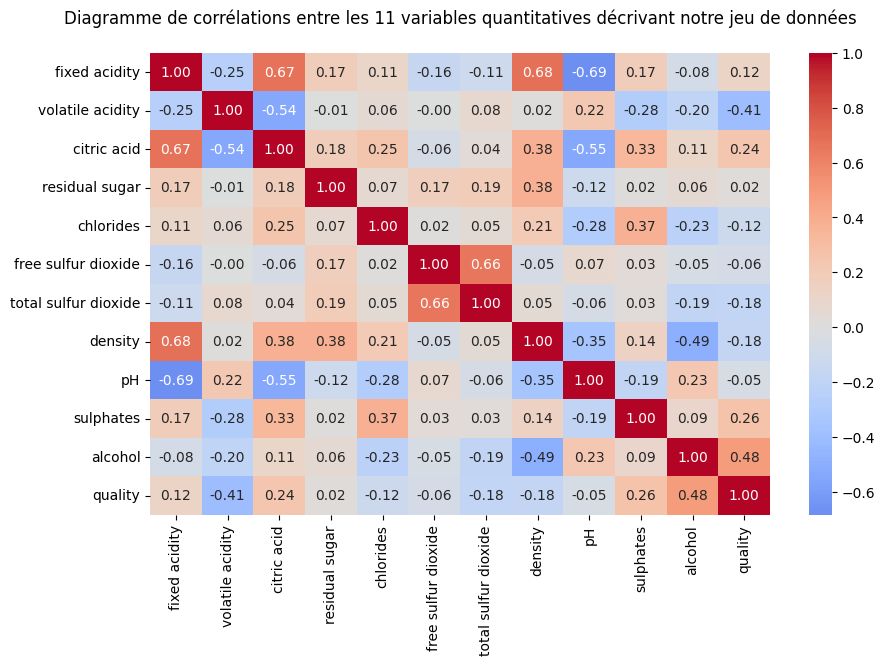

In [10]:
# Heatmap
plt.figure(figsize=(10, 6))
# wine_quantitative = data.drop(columns="quality")
# sns.heatmap(wine_quantitative.corr(), annot=True, fmt=".2f", cmap="coolwarm", center=0)
sns.heatmap(data.corr(), annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title(
    f"Diagramme de corrélations entre les 11 variables quantitatives décrivant notre jeu de données\n"
)
plt.show()

# nuage de points 2 à 2 de toutes les variables
sns.pairplot(data, hue="quality", diag_kind="kde", palette="Set2")
plt.show()

Voici les couples de variables qui ont les corrélations les plus fortes et qui pourraient se rapprocher le plus d'une corrélation linéaire :  
*Nous vérifions graphiquement pour une éventuelle linéarité et ce n'est pas vraiment le cas ici, on parlera plutôt de tendance linéaire.*  
- L'acidité fixe et le pH (de manière négative), c'est-à-dire que plus l'acidité fixe est élevée, plus le vin est acide (pH bas).
- L'acidité fixe et la densité (de manière positive), c'est-à dire que plus l'acidité fixe est élevée plus la densité l'est aussi. 
- L'acidité fixe et l'acide citrique (de manière positive), c'est-à dire que plus la quantité d'acide citrique semble élevée plus l'acidité fixe semble l'être aussi.  

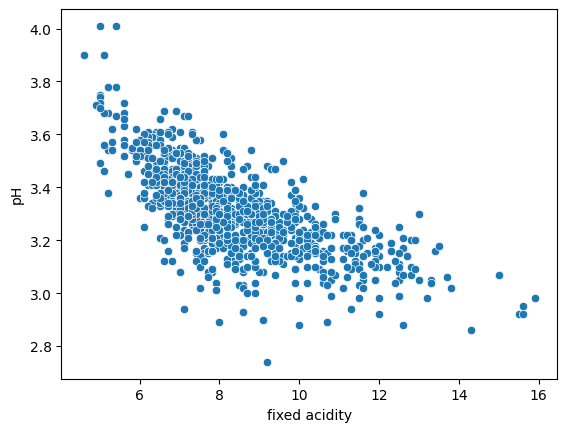

In [11]:
# sns.scatterplot(x="pH", y="fixed acidity", data=data)
sns.scatterplot(x="fixed acidity", y="pH", data=data)
plt.show()

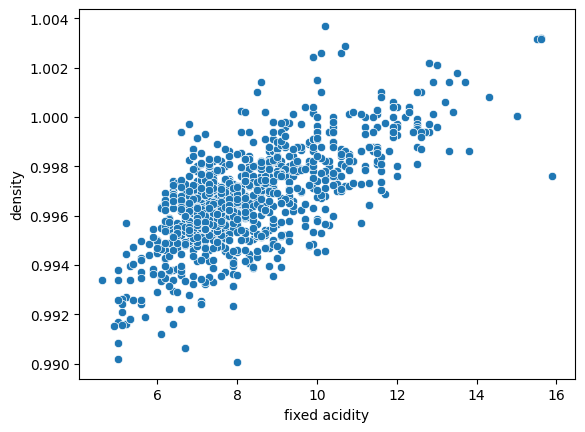

In [12]:
# sns.scatterplot(x="density", y="fixed acidity", data=data)
sns.scatterplot(x="fixed acidity", y="density", data=data)
plt.show()

In [13]:
# sns.scatterplot(x="citric acid", y="fixed acidity", data=data)
sns.scatterplot(x="citric acid", y="fixed acidity", data=data)
plt.show()

On constate blablabla

## 3 - Nettoyage des données

---

### a. Suppression des valeurs manquantes

In [14]:
# Vérification des valeurs manquantes
missing_values: pd.Series = data.isnull().sum()
missing_columns: pd.Series = missing_values[missing_values > 0]

if not missing_columns.empty:
    print("Colonnes avec des valeurs manquantes :")
    for col, count in missing_columns.items():
        print(f"- {col} : {count} valeurs manquantes")

    # Suppression des lignes avec des valeurs manquantes
    initial_count: int = len(data)
    data: pd.DataFrame = data.dropna()
    final_count: int = len(data)
    print(
        f"{initial_count - final_count} lignes supprimées en raison de valeurs manquantes."
    )
else:
    print("Aucune valeur manquante détectée.")

Aucune valeur manquante détectée.


### b. Suppressions des doublons

In [15]:
# Doublons
if data.duplicated().sum() > 0:
    print(f"Doublons trouvés : {data.duplicated().sum()} lignes suprimées.")
    # Suppression des doublons
    data.drop_duplicates(inplace=True)
    data.reset_index(drop=True, inplace=True)
else:
    print("Aucun doublon trouvé.")

Doublons trouvés : 125 lignes suprimées.


In [16]:
# Informations générales après suppression de doublons
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1018 entries, 0 to 1017
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1018 non-null   float64
 1   volatile acidity      1018 non-null   float64
 2   citric acid           1018 non-null   float64
 3   residual sugar        1018 non-null   float64
 4   chlorides             1018 non-null   float64
 5   free sulfur dioxide   1018 non-null   float64
 6   total sulfur dioxide  1018 non-null   float64
 7   density               1018 non-null   float64
 8   pH                    1018 non-null   float64
 9   sulphates             1018 non-null   float64
 10  alcohol               1018 non-null   float64
 11  quality               1018 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 95.6 KB


In [17]:
# Statistiques descriptives après suppression de doublons
data.describe()

fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1018.000000       1018.000000  1018.000000     1018.000000   
mean        8.288507          0.533541     0.268802        2.524411   
std         1.741324          0.183167     0.196229        1.314850   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.390000     0.090000        1.900000   
50%         7.900000          0.520000     0.250000        2.200000   
75%         9.100000          0.645000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1018.000000          1018.000000           1018.000000  1018.000000   
mean      0.087187            15.648821             46.325639     0.996700   
std       0.048506            10.176525             33.123533     0.001916   
min       0.012000             1.000000              6.000000     0.990070   
25%       0.070000             7.000000             21.000000     0.995572   
50%       0.079000            13.000000             38.000000     0.996665   
75%       0.090000            21.000000             62.000000     0.997827   
max       0.611000            68.000000            289.000000     1.003690   

                pH    sulphates      alcohol      quality  
count  1018.000000  1018.000000  1018.000000  1018.000000  
mean      3.311503     0.656817    10.452456     5.641454  
std       0.157775     0.167542     1.095064     0.811744  
min       2.740000     0.330000     8.400000     3.000000  
25%       3.210000     0.550000     9.500000     5.000000  
50%       3.310000     0.620000    10.200000     6.000000  
75%       3.400000     0.720000    11.200000     6.000000  
max       4.010000     2.000000    14.900000     8.000000

### c. Normalisation des features

La normalisation est nécessaire pour mettre toutes les variables sur la même échelle afin d’éviter qu’une variable comme l’alcool, avec une amplitude plus grande, ne domine les autres dans les méthodes sensibles aux distances comme l’ACP ou le K-means. Ci-dessous, nous comparons les données avant et après normalisation

**Aperçu des données avant normalisation :**

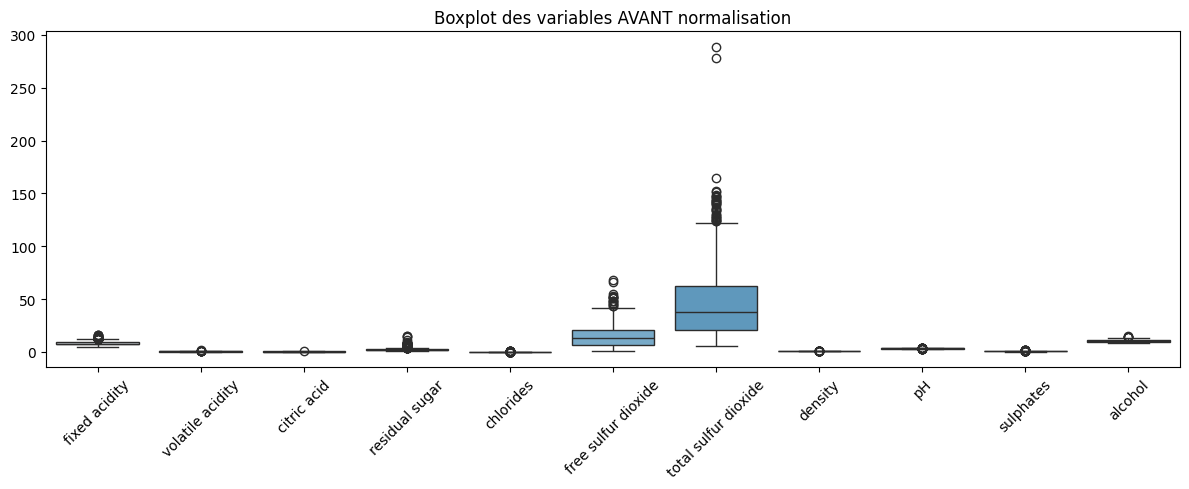

In [18]:
# Sauvegarde de l'index Id
ids: Index = data.index.copy()

# Sélection des variables quantitatives (hors quality et Id si présent)
features: List[str] = (
    data.drop(columns=["quality", "Id"], errors="ignore")
    .select_dtypes(include=["float64", "int64"])
    .columns.tolist()
)

# Sous-ensemble des features
data_features: DataFrame = data[features]

# Histoplot avant normalisation
plt.figure(figsize=(14, 8))
for i, column in enumerate(data_features.columns, 1):
    plt.subplot(4, 3, i)
    sns.histplot(
        data_features[column], bins=20, kde=True, color="skyblue", edgecolor="black"
    )
    plt.title(column)
plt.suptitle("Distributions des variables AVANT normalisation", fontsize=16)
plt.tight_layout()
plt.show()

# Boxplot avant normalisation
plt.figure(figsize=(12, 5))
sns.boxplot(data=data_features, palette="Blues")
plt.title("Boxplot des variables AVANT normalisation")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Les histogrammes montrent que certaines variables comme `alcohol`, `residual sugar` ou `total sulfur dioxide` ont des échelles de valeurs beaucoup plus grandes que d'autres comme `chlorides` ou `sulphates`.

Les boxplots confirment cette hétérogénéité : les amplitudes diffèrent fortement d'une variable à l'autre, ce qui pourrait biaiser les analyses basées sur la distance (comme l’ACP ou les clusters).
Certaines variables montrent aussi des valeurs extrêmes (outliers), comme `total sulfur dioxide` ou `residual sugar`.

Pour régler cela, nous utilisons le `StandardScaler` de la librairie `sklearn`. Celui-ci normalise simplement les variables $p_i$ grâce au TCL : $$p_{i_{\text{normalisé}}} = \frac{p_i - \mathbb{E}(p_i)}{\sqrt{\text{Var}(p_i)}}$$

In [19]:
# Normalisation avec StandardScaler
scaler: StandardScaler = StandardScaler()
data_normalized: DataFrame = pd.DataFrame(
    scaler.fit_transform(data_features),
    columns=features,
    index=ids,  # pour garder la correspondance avec l’index d’origine
)

**Aperçu des données après normalisation :**

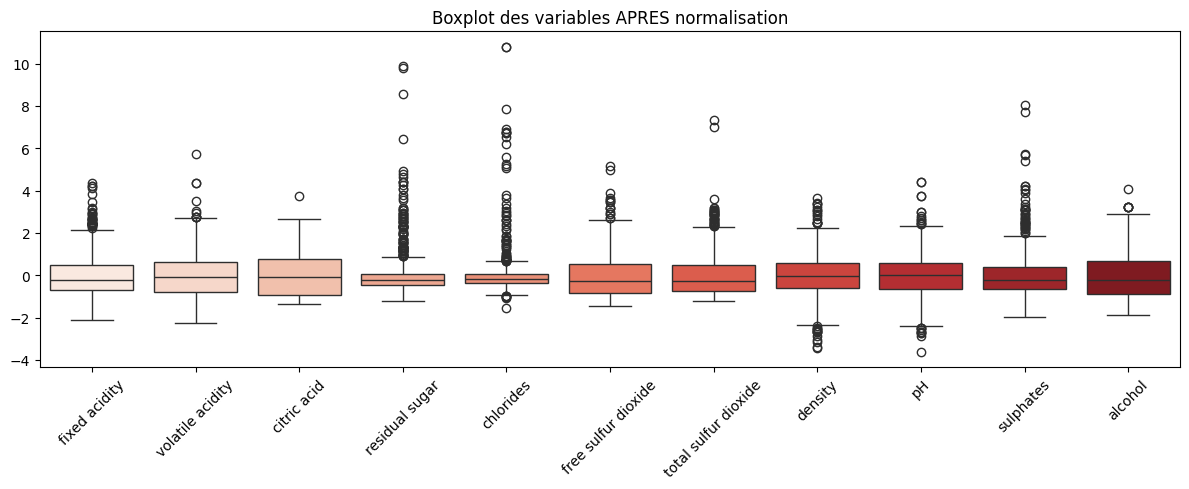

In [20]:
# Histoplot avant normalisation
plt.figure(figsize=(14, 8))
for i, column in enumerate(data_normalized.columns, 1):
    plt.subplot(4, 3, i)
    sns.histplot(
        data_normalized[column], bins=20, kde=True, color="salmon", edgecolor="black"
    )
    plt.title(column)
plt.suptitle("Distributions des variables APRES normalisation", fontsize=16)
plt.tight_layout()
plt.show()

# Boxplot avant normalisation
plt.figure(figsize=(12, 5))
sns.boxplot(data=data_normalized, palette="Reds")
plt.title("Boxplot des variables APRES normalisation")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Après normalisation, toutes les variables ont une distribution centrée autour de 0 avec un écart-type d’environ 1 (ce qui correspond à la distribution d'une loi normale centrée réduite). Cela rend les variables comparables, indépendamment de leur unité ou échelle initiale.

Les boxplots montrent des amplitudes similaires entre toutes les variables, ce qui est essentiel pour appliquer des méthodes sensibles à l’échelle comme l’ACP, la K-means, ou les algorithmes à base de distances.  
Les valeurs extrêmes sont conservées mais deviennent moins influentes dans les calculs.
Les données originales sont remplacées par les données normalisées par le `StandardScaler` dans le DataFrame

In [21]:
# Mise à jour du DataFrame avec les données normalisées
data[features] = data_normalized[features]
# On s'assure que l'index est bien "Id"
data.index.name = "Id"
# Vérification
data.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
Id                                                                            
0       -0.510499          0.909227    -1.370507       -0.475125  -0.230739   
1       -0.280676          1.892418    -1.370507        0.057517   0.223040   
2       -0.280676          1.236957    -1.166564       -0.170758   0.099282   
3        1.672822         -1.384886     1.484700       -0.475125  -0.251365   
4       -0.510499          0.690740    -1.370507       -0.551216  -0.251365   

    free sulfur dioxide  total sulfur dioxide   density        pH  sulphates  \
Id                                                                             
0             -0.457043             -0.372294  0.574517  1.258719  -0.578153   
1              0.919349              0.624466  0.052448 -0.707068   0.138438   
2             -0.063788              0.231803  0.156862 -0.326593  -0.040710   
3              0.132839              0.413032  0.678931 -0.960718  -0.458721   
4             -0.260415             -0.191065  0.574517  1.258719  -0.578153   

     alcohol  quality  
Id                     
0  -0.961563        5  
1  -0.596108        5  
2  -0.596108        5  
3  -0.596108        6  
4  -0.961563        5

In [22]:
# Statistiques descriptives après normalisation
data.describe()

fixed acidity  volatile acidity   citric acid  residual sugar  \
count   1.018000e+03      1.018000e+03  1.018000e+03    1.018000e+03   
mean   -7.258983e-16      2.024139e-16 -2.791916e-17   -3.978481e-16   
std     1.000492e+00      1.000492e+00  1.000492e+00    1.000492e+00   
min    -2.119261e+00     -2.258834e+00 -1.370507e+00   -1.236041e+00   
25%    -6.828662e-01     -7.840473e-01 -9.116348e-01   -4.751245e-01   
50%    -2.232198e-01     -7.396470e-02 -9.586139e-02   -2.468495e-01   
75%     4.662499e-01      6.088070e-01  7.708979e-01    5.751724e-02   
max     4.373245e+00      5.715939e+00  3.728076e+00    9.873344e+00   

          chlorides  free sulfur dioxide  total sulfur dioxide       density  \
count  1.018000e+03         1.018000e+03          1.018000e+03  1.018000e+03   
mean  -1.395958e-16        -8.375749e-17         -1.116767e-16 -3.685330e-15   
std    1.000492e+00         1.000492e+00          1.000492e+00  1.000492e+00   
min   -1.550822e+00        -1.440179e+00         -1.218030e+00 -3.461076e+00   
25%   -3.544968e-01        -8.502974e-01         -7.649572e-01 -5.883917e-01   
50%   -1.688601e-01        -2.604153e-01         -2.514747e-01 -1.803138e-02   
75%    5.802920e-02         5.260940e-01          4.734418e-01  5.888738e-01   
max    1.080433e+01         5.146837e+00          7.329944e+00  3.649503e+00   

                 pH     sulphates       alcohol      quality  
count  1.018000e+03  1.018000e+03  1.018000e+03  1018.000000  
mean  -1.703069e-15  1.095827e-15 -5.583833e-17     5.641454  
std    1.000492e+00  1.000492e+00  1.000492e+00     0.811744  
min   -3.624041e+00 -1.951619e+00 -1.875200e+00     3.000000  
25%   -6.436552e-01 -6.378690e-01 -8.701991e-01     5.000000  
50%   -9.530557e-03 -2.198577e-01 -2.306530e-01     6.000000  
75%    5.611816e-01  3.773012e-01  6.829842e-01     6.000000  
max    4.429342e+00  8.020936e+00  4.063442e+00     8.000000

In [23]:
# Sauvegarde du DataFrame normalisé
data.to_csv(
    os.path.join(os.path.dirname(os.getcwd()),
                 "data", "WineQT_normalized.csv"),
    index=True,
)

## 4 - Regroupement arbitraire de la variable `quality` selon la distribution

---

La variable `quality` représente une note attribuée aux vins (entre 0 et 10). Cependant, cette note :
- est **discrète** et **centrée** autour de valeurs moyennes (notamment 5, 6 et 7),
- semble issue d’un **vote ou jugement subjectif** (rarement extrême : seules les variables allant de 3 à 8 sont présentes),
- n'est pas répartie uniformément.

Nous explorons ici différentes approches pour **justifier ou non un regroupement en classes**, à travers :
- des visualisations
- l’étude de la distribution empirique (quantiles)
- une classification hiérarchique avec la méthode de Ward

### a. Visualisation de la variable `quality`

#### Diagramme en barre des notes de qualité

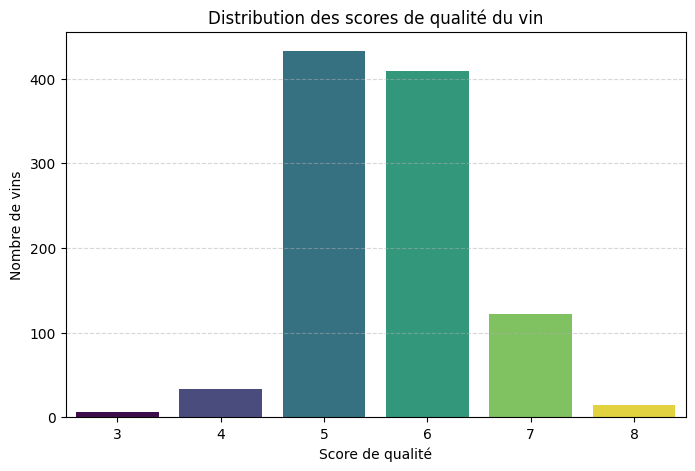

In [24]:
plt.figure(figsize=(8, 5))
sns.countplot(x="quality", data=data, hue="quality",
              palette="viridis", legend=False)
plt.title("Distribution des scores de qualité du vin")
plt.xlabel("Score de qualité")
plt.ylabel("Nombre de vins")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

#### Estimation de la densité par la méthode des noyaux (KDE - *Kernel Density Estimation*)

Pour cela, nous utilisons le noyau gaussien définit ci-dessous : $$K(x) = \frac{1}{\sqrt{2\pi}}\exp\left(-\frac{1}{2}x^2\right)$$

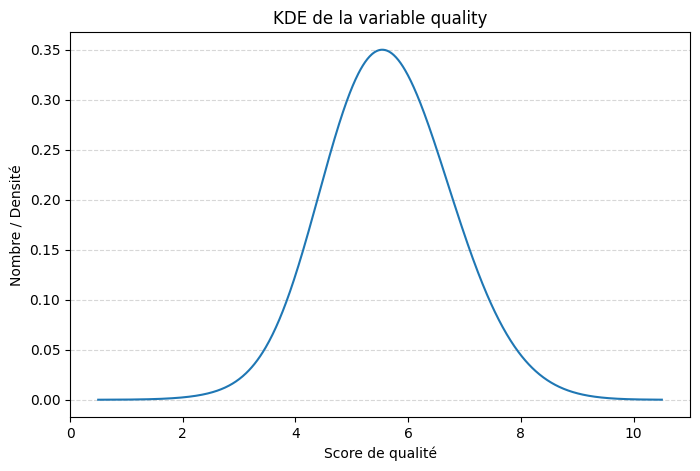

In [25]:
plt.figure(figsize=(8, 5))
data["quality"].plot.kde(bw_method=1)
plt.title("KDE de la variable quality")
plt.xlabel("Score de qualité")
plt.ylabel("Nombre / Densité")
plt.grid(True, axis="y", linestyle="--", alpha=0.5)
plt.show()

**Analyse du diagramme en barre** :

- Distribution fortement asymétrique : les scores sont concentrés autour des valeurs 5 et 6.
- Les scores extrêmes (3, 4, 7, 8) sont très peu représentés.

**Analyse du KDE** :

- Cela confirme une distribution centrée autour d’une mode, avec une faible dispersion.
- Le distribution des classes suit approximativement une distribution normale de moyenne 5.5

**Possible regroupement ?** :

- Le nombre de classes étant élevé, il serait peut-être judicieux de regrouper des classes pour rendre l'analyse plus simple.
- Un regroupement naturel serait :
    - **Classe basse** : 3–4
    - **Classe moyenne** : 5–6 (le cœur de la distribution)
    - **Classe haute** : 7–8
- Mais est-ce le regroupement le plus représentatif de l'échantillon ?



### b. Regroupement de la variable `quality` en 3 classes
#### Courbe de répartition cumulative + seuils

Supposons que nous voulons regrouper les différentes valeurs de la classe cible en 3 classes le plus équitablement possible. Pour cela, nous pouvons calculer les quantiles des multiples du tiers.

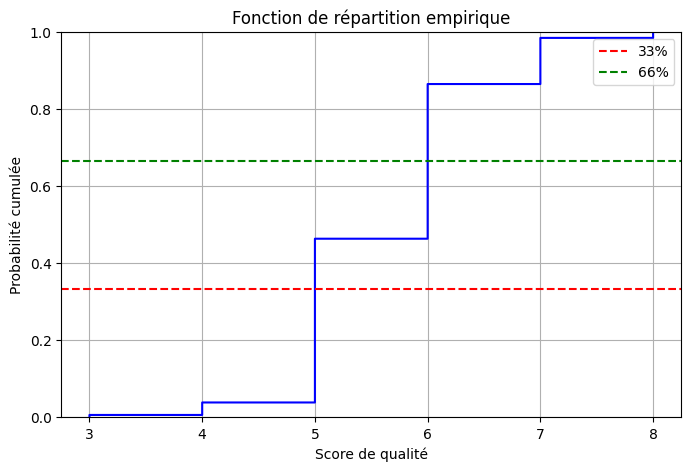

Seuils quantiles 33% / 66% :
0.33    5.0
0.66    6.0
Name: quality, dtype: float64


In [26]:
plt.figure(figsize=(8, 5))
sns.ecdfplot(data["quality"], color="blue")
plt.axhline(1 / 3, linestyle="--", color="red", label="33%")
plt.axhline(2 / 3, linestyle="--", color="green", label="66%")
plt.title("Fonction de répartition empirique")
plt.xlabel("Score de qualité")
plt.ylabel("Probabilité cumulée")
plt.legend()
plt.grid(True)
plt.show()

# Affichage des quantiles
print("Seuils quantiles 33% / 66% :")
print(data["quality"].quantile([0.33, 0.66]))

**Interpretations**
- Nous pouvons construire un regroupement ternaire équilibré comme suit :
    - Qualité faible : ≤ 5
    - Qualité moyenne : = 6
    - Qualité élevée : ≥ 7
- Cette répartition améliore l'equilibre entre les classes, ce qui est souvent utile pour l’apprentissage supervisé (voir le diagramme ci-dessous)

**Avantage** : Ce seuil basé sur les quantiles optimise l’égalité des classes.

**Limite** : La valeur 6 étant centrale, elle peut appartenir à une classe moyenne ou élevée, selon la stratégie.

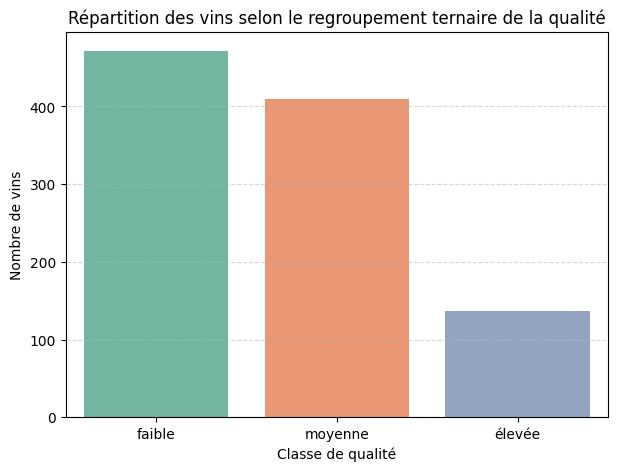

quality_group
faible     472
moyenne    409
élevée     137
Name: count, dtype: int64


In [27]:
# Regroupement en 3 classes basé sur les quantiles
def assign_quality_group(quality: int) -> str:
    if quality <= 5:
        return "faible"
    elif quality == 6:
        return "moyenne"
    else:  # quality >= 7
        return "élevée"


data_3cls = data.copy()
data_3cls["quality_group"] = data["quality"].apply(assign_quality_group)

# Affichage des effectifs par classe
plt.figure(figsize=(7, 5))
sns.countplot(
    x="quality_group",
    data=data_3cls,
    hue="quality_group",
    legend=False,
    palette="Set2",
    order=["faible", "moyenne", "élevée"],
)
plt.title("Répartition des vins selon le regroupement ternaire de la qualité")
plt.xlabel("Classe de qualité")
plt.ylabel("Nombre de vins")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

# Affichage des effectifs (en complément)
print(data_3cls["quality_group"].value_counts())

### c. Regroupement de la variable `quality` en 4 classes
#### Courbe de répartition cumulative + seuils

Supposons que nous voulons regrouper les différentes valeurs de la classe cible en 4 classes le plus équitablement possible. Pour cela, nous pouvons calculer les quantiles des multiples du quart.

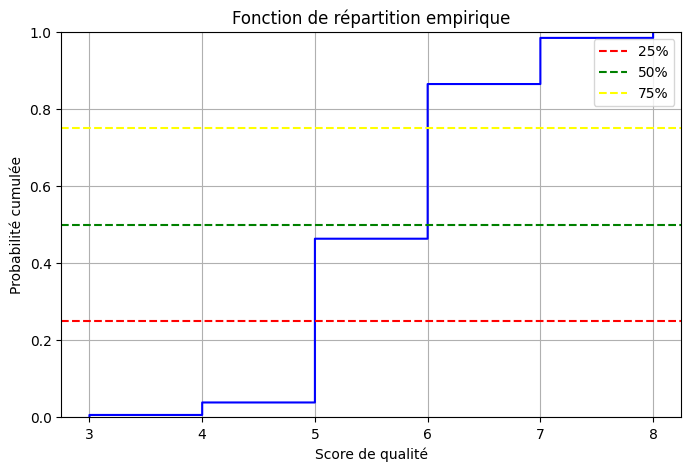

Seuils quantiles 25% / 50% / 75% :
0.25    5.0
0.50    6.0
0.75    6.0
Name: quality, dtype: float64


In [28]:
plt.figure(figsize=(8, 5))
sns.ecdfplot(data["quality"], color="blue")
plt.axhline(1 / 4, linestyle="--", color="red", label="25%")
plt.axhline(1 / 2, linestyle="--", color="green", label="50%")
plt.axhline(3 / 4, linestyle="--", color="yellow", label="75%")
plt.title("Fonction de répartition empirique")
plt.xlabel("Score de qualité")
plt.ylabel("Probabilité cumulée")
plt.legend()
plt.grid(True)
plt.show()

# Affichage des quantiles
print("Seuils quantiles 25% / 50% / 75% :")
print(data["quality"].quantile([0.25, 0.5, 0.75]))

**Interpretations**
- Nous pouvons construire un regroupement quaternaire comme suit :
    - Qualité faible : ≤ 5
    - Qualité moyenne basse : = 6
    - Qualité moyenne haute : = 6
    - Qualité haute : ≥ 7
- Cette répartition n'améliore pas l'équilibre du regroupement ternaire, puisque la classe correspondant au troisième quartile est totalement écrasée par la précédente. Le regroupement ternaire semble être plus adéquat

### d. Méthode de Ward
Au lieu d'utiliser des méthodes arbitraires en essayant de diviser équitablement la répartition des classes, nous pouvons utiliser la classification hiérarchique pour regrouper intelligemment les classes. Pour cela, nous allons utiliser la méthode de Ward utilisant la distance ci-dessous :
$$D(A,B) = \frac{n_An_B}{n_A+n_B}d^2(g_A,g_B)$$
Nous pouvons alors construire un dendrogramme, puis utiliser un seuil pour obtenir une partition.

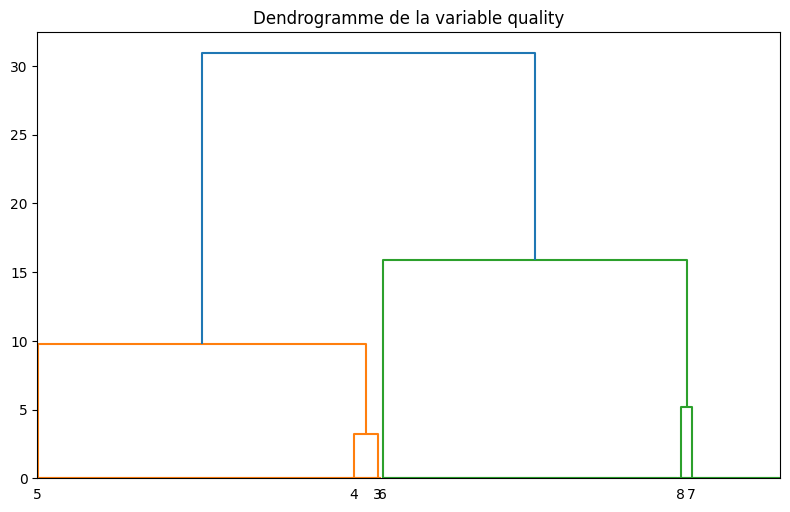

In [29]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    default_kwargs = dict(leaf_font_size=10)
    default_kwargs.update(kwargs or {})

    dendrogram(linkage_matrix, **default_kwargs)


cls = AgglomerativeClustering(
    metric="euclidean", linkage="ward", distance_threshold=0, n_clusters=None
)
cls.fit(data["quality"].to_frame())
plt.figure(figsize=(8, 5))

# Générer les labels : un seul affiché par groupe
labels_raw = data["quality"].values
labels_custom = [""] * len(labels_raw)

# On garde la première occurrence de chaque valeur
last_indices = {}
for i in range(len(labels_raw) - 1, -1, -1):
    val = labels_raw[i]
    if val not in last_indices:
        last_indices[val] = i
        labels_custom[i] = str(val)

plot_dendrogram(cls, labels=labels_custom)
plt.tick_params(axis="x", labelrotation=0)  # rotation 0 = vertical
plt.tight_layout()
plt.title("Dendrogramme de la variable quality")
plt.show()

Ce dendrogramme nous informe sur les différentes partitions possibles si nous utilisons la méthode de Ward dans une classification hiérarchique. Elles sont modélisées comme suit :
$$\begin{array}{rcccccccccccl}\text{6 classes : }\{&3&\},\{&4&\},\{&5&\},\{&6&\},\{&7&\},\{&8&\} \\ \text{5 classes : }\{&3&,&4&\},\{&5&\},\{&6&\},\{&7&\},\{&8&\} \\ \text{4 classes : }\{&3&,&4&\},\{&5&\},\{&6&\},\{&7&,&8&\} \\ \text{3 classes : }\{&3&,&4&,&5&\},\{&6&\},\{&7&,&8&\} \\ \text{2 classes : }\{&3&,&4&,&5&\},\{&6&,&7&,&8&\} \\ \text{1 classe : }\{&3&,&4&,&5&,&6&,&7&,&8&\}\end{array}$$

## 5 - Approche non supervisée du regroupement

---
### a. Identification de groupes naturels

Avant de choisir arbitrairement un regroupement, on peut explorer si les données forment **naturellement des groupes homogènes**.

Pour cela, nous appliquons les différentes méthodes :
- méthode des centres mobiles
- méthode du coude
- score de Silouhette

Ces outils nous aident à choisir **le nombre optimal de classes**.

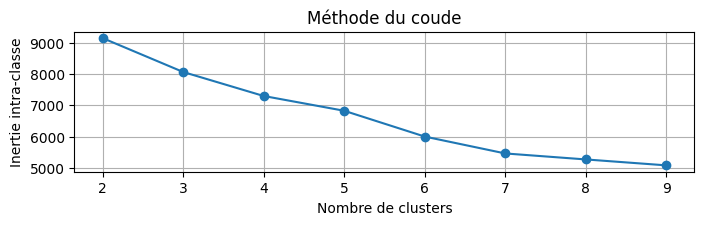

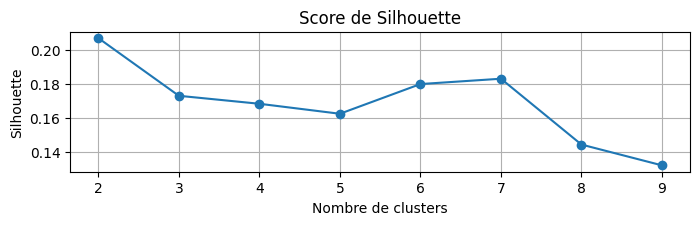

In [30]:
# Recueil des données déjà normalisées
norm_data = data.drop(columns=["quality"])

# Tests pour différents k
inerties: list[float] = []
silhouettes: list[float] = []
K_range: range = range(2, 10)

for k in K_range:
    model = KMeans(n_clusters=k, random_state=42, n_init="auto").fit(norm_data)
    inerties.append(model.inertia_)
    silhouettes.append(silhouette_score(data, model.labels_))

# Courbe du coude
plt.figure(figsize=(8, 4))
plt.subplot(2, 1, 1)
plt.plot(K_range, inerties, marker="o")
plt.title("Méthode du coude")
plt.xlabel("Nombre de clusters")
plt.ylabel("Inertie intra-classe")
plt.grid(True)
plt.show()
plt.figure(figsize=(8, 4))
plt.subplot(2, 1, 2)
plt.plot(K_range, silhouettes, marker="o")
plt.title("Score de Silhouette")
plt.xlabel("Nombre de clusters")
plt.ylabel("Silhouette")
plt.grid(True)
plt.show()

**Interprétation des résultats de la méthode du coude** :
- Le coude le plus visible est à k = 4 ou k = 7 (coude très léger).
- Comme il n'y a que 6 classes, la meilleure solution semble être k=4

**Interprétation du score de Silouhette** :
- Les meilleurs résulats semblent être k = 4,5 ou k=8,9
- Comme nous n'avons que 6 classes, la meilleure solution semble être k=4 ou k=5

**Conclusion** :
- Le coude est un critère d’optimisation de l’inertie intra-classe.
- Cela valide statistiquement l’hypothèse d’un regroupement en 4 clusters naturels, compatible avec :
    - la densité de la distribution,
    - les quantiles,
    - la sémantique métier (bas / moyenne basse / moyenne haute / haut).
- Si nous gardons k=6 cela signifie que nous gardons les données initiales sans les regrouper

### b - Visualisation des clusters naturels de `quality` grâce à l'ACP

Précédement, nous avons trouvé que la variable cible `quality` était séparée en 4 classes naturelles. Dans cette partie, l'ACP va nous permettre de visualiser ces différentes classes en fonction des composantes principales.

Le principe de l'ACP est de diminuer la dimension d'un jeu de données grâce à des combinaisons linéaires des variables. Pour savoir combien de composantes principales nous allons garder pour les projections, nous affichons l'inertie expliquée cumulée en fonction des composantes principales.

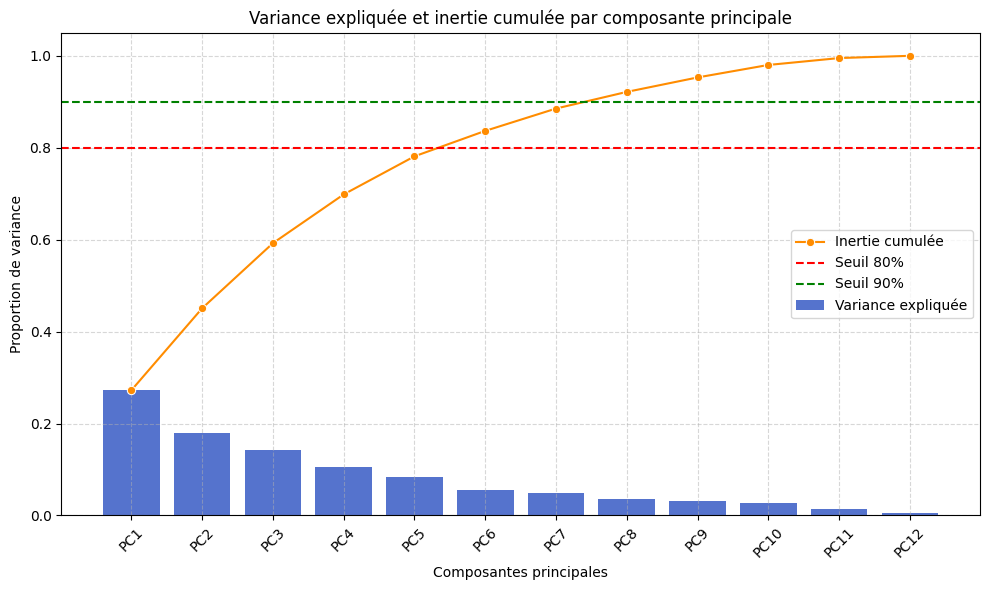

In [31]:
# Génération du diagramme complet avec toutes les composantes principales

# Utilisation de la classe PCA de sklearn
pca = PCA()
data_pca = pca.fit_transform(data)

# Extraction de l'inertie expliquée (variance)
explained_variance_ratio = pca.explained_variance_ratio_
explained_variance_cumsum = explained_variance_ratio.cumsum()

# Création de la figure combinée
plt.figure(figsize=(10, 6))

# Barres : variance expliquée par chaque composante
sns.barplot(
    x=[f"PC{i+1}" for i in range(len(explained_variance_ratio))],
    y=explained_variance_ratio,
    color="royalblue",
    label="Variance expliquée",
)

# Courbe : inertie cumulée
sns.lineplot(
    x=range(len(explained_variance_cumsum)),
    y=explained_variance_cumsum,
    marker="o",
    color="darkorange",
    label="Inertie cumulée",
)

# Réglages esthétiques
plt.axhline(y=0.80, color="red", linestyle="--", label="Seuil 80%")
plt.axhline(y=0.90, color="green", linestyle="--", label="Seuil 90%")
plt.title("Variance expliquée et inertie cumulée par composante principale")
plt.xlabel("Composantes principales")
plt.ylabel("Proportion de variance")
plt.xticks(rotation=45)
plt.ylim(0, 1.05)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

Nous allons donc effectuer :

1. Une projection des individus sur 2 composantes principales (ce qui nous permettra de facilement visualiser les données sur un plan et d'identifier les groupes naturels).
2. Une projection sur 5 composantes principales, qui couvrent environ 80% de la variance totale.

Pour chacune des projections, nous allons visualiser le résultat avec 4 et 6 clusters pour nous aider à prendre une décision sur le regroupement.

Cela permet :

- d’évaluer la qualité de la représentation des individus,
- d'observer les séparations potentielles entre classes (par qualité ou clusters),
- de décider si une réduction de dimension à 2 composantes est suffisante pour une visualisation ou une modélisation.

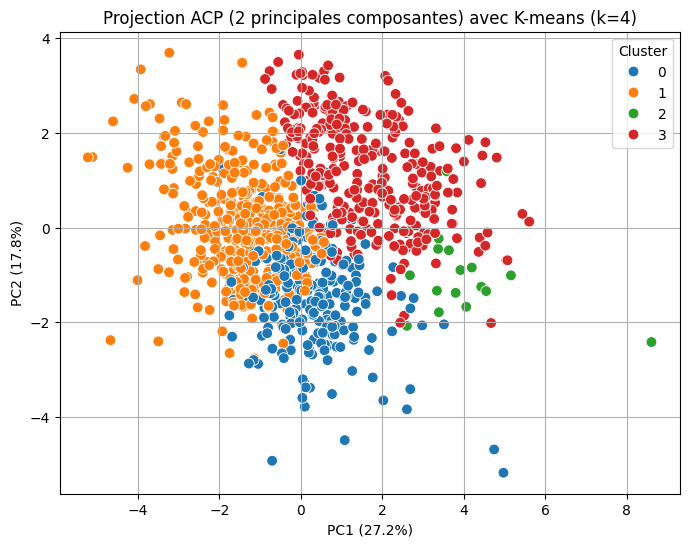

In [32]:
# Projetction PCA avec 2 composantes principales et K=4

pca_2 = PCA(n_components=2)
#!Warning: X has to be normalized
data_pca_2: pd.DataFrame = pca_2.fit_transform(data)

# K-means avec k=4
kmeans_4 = KMeans(n_clusters=4, random_state=42)
labels_4: list[int] = kmeans_4.fit_predict(data)

# Visualisation
df_plot = pd.DataFrame(data_pca_2, columns=["PC1", "PC2"])
df_plot["cluster"] = labels_4

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_plot, x="PC1", y="PC2",
                hue="cluster", palette="tab10", s=60)
plt.title("Projection ACP (2 principales composantes) avec K-means (k=4)")
plt.xlabel(f"PC1 ({pca_2.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca_2.explained_variance_ratio_[1]*100:.1f}%)")
plt.grid(True)
plt.legend(title="Cluster")
plt.show()

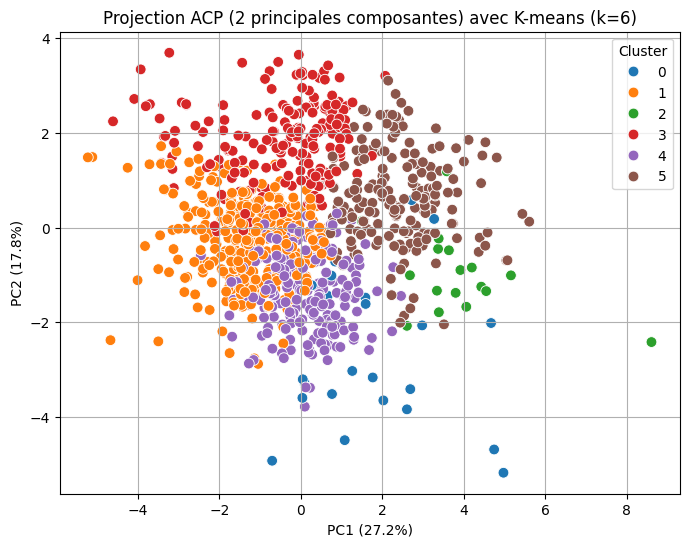

In [33]:
# Projection PCA avec 2 composantes principales et K=6

# K-means avec k=6
kmeans_6 = KMeans(n_clusters=6, random_state=42)
#!Warning: X has to be normalized
labels_6: list[int] = kmeans_6.fit_predict(data)

# Visualisation
df_plot = pd.DataFrame(data_pca_2, columns=["PC1", "PC2"])
df_plot["cluster"] = labels_6

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_plot, x="PC1", y="PC2",
                hue="cluster", palette="tab10", s=60)
plt.title("Projection ACP (2 principales composantes) avec K-means (k=6)")
plt.xlabel(f"PC1 ({pca_2.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca_2.explained_variance_ratio_[1]*100:.1f}%)")
plt.grid(True)
plt.legend(title="Cluster")
plt.show()

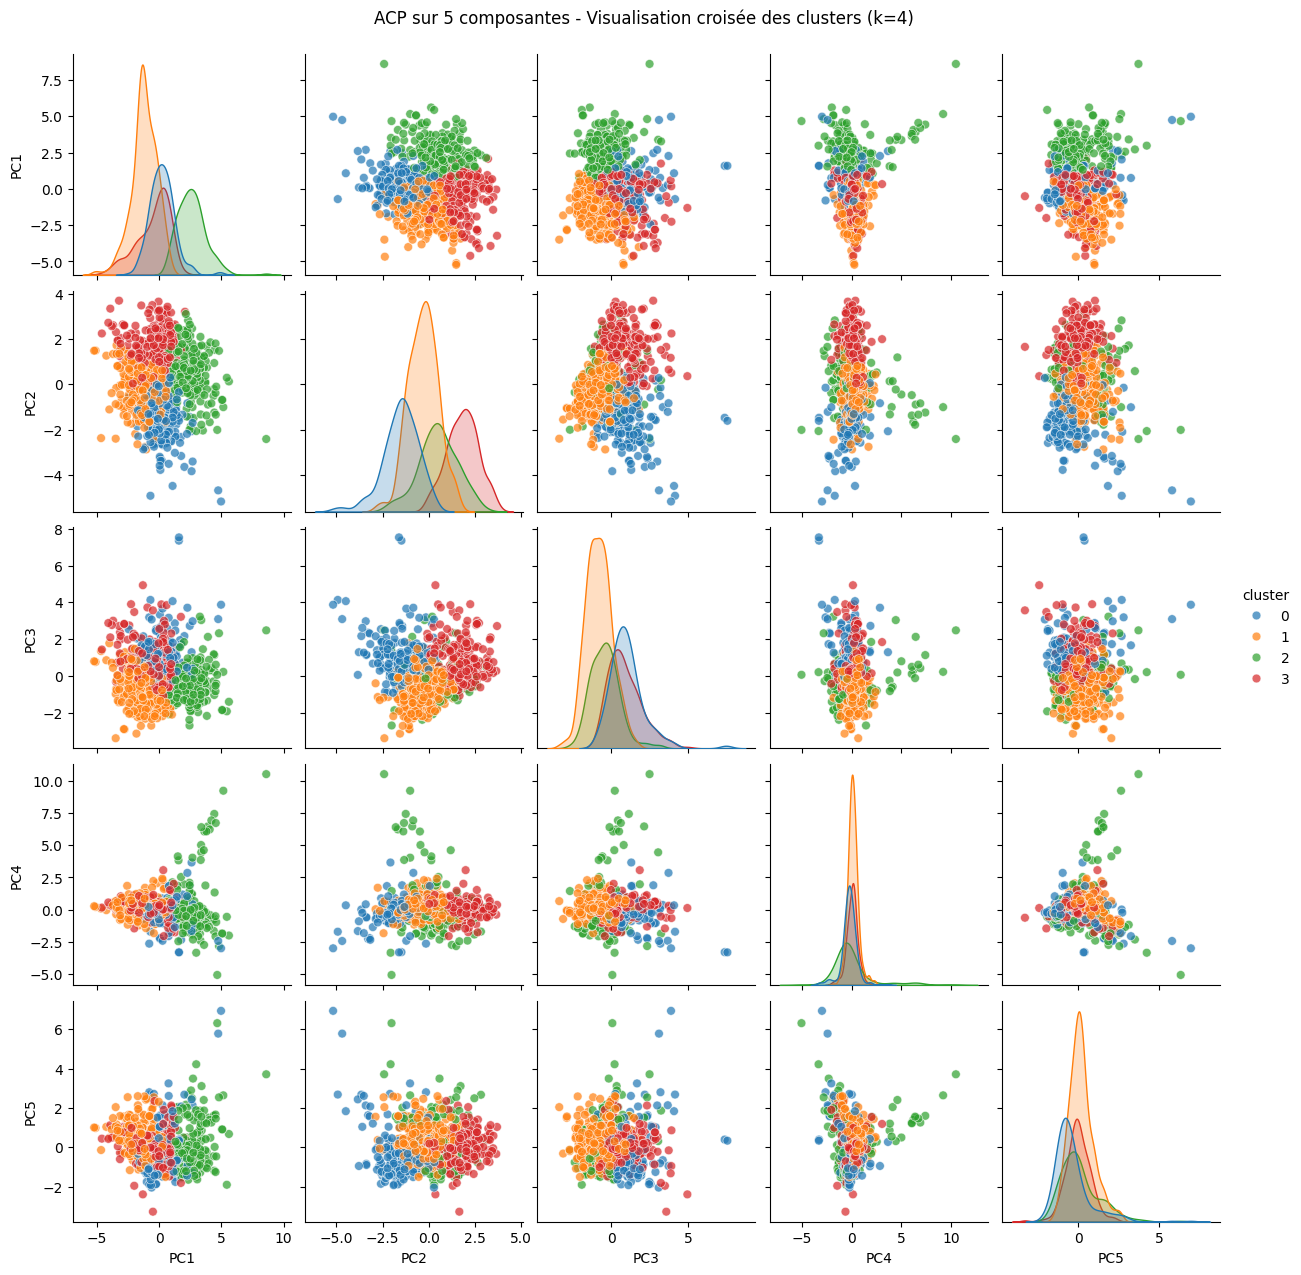

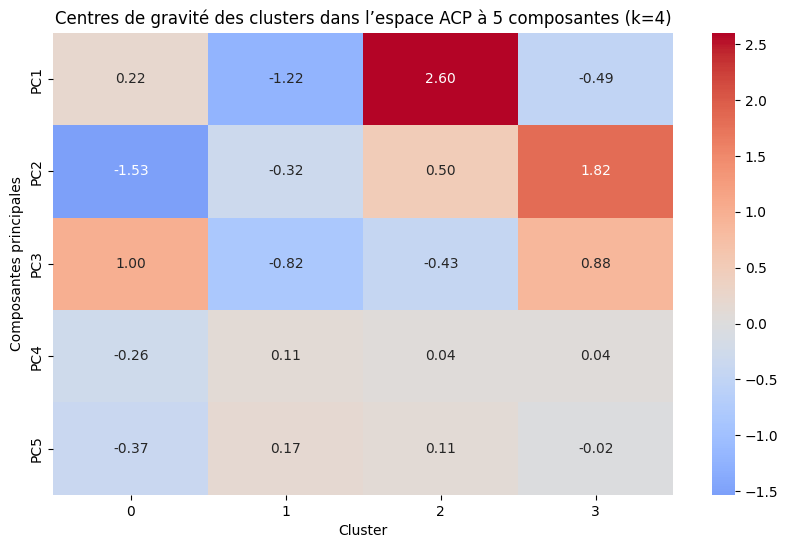

Inertie intra-classe moyenne du cluster 0 : 5.254
Inertie intra-classe moyenne du cluster 1 : 3.258
Inertie intra-classe moyenne du cluster 2 : 9.208
Inertie intra-classe moyenne du cluster 3 : 4.590

Inertie inter-classe      : 4038.39
Inertie intra-classe totale : 5234.34
Inertie totale              : 9272.73
Taux d'inertie expliquée    : 43.55%


In [34]:
# Projection ACP avec 5 composantes principales et K=4
# ACP à 5 composantes
pca_5 = PCA(n_components=5)
data_pca_5: pd.DataFrame = pca_5.fit_transform(data)

# K-means avec k=4
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
clusters: list[int] = kmeans.fit_predict(data_pca_5)

# Construction du dataframe pour le pairplot
df_pca_pairplot = pd.DataFrame(
    data_pca_5, columns=[f"PC{i+1}" for i in range(5)])
df_pca_pairplot["cluster"] = clusters

# Affichage
sns.pairplot(
    df_pca_pairplot, hue="cluster", palette="tab10", plot_kws={"alpha": 0.7, "s": 40}
)
plt.suptitle(
    f"ACP sur 5 composantes - Visualisation croisée des clusters (k={k})", y=1.02
)
plt.show()

# Moyennes des composantes principales par cluster
df_means = df_pca_pairplot.groupby("cluster").mean()

# Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df_means.T, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title(
    f"Centres de gravité des clusters dans l’espace ACP à 5 composantes (k={k})")
plt.xlabel("Cluster")
plt.ylabel("Composantes principales")
plt.show()

# Calcul de l’inertie intra-classe manuellement
inertie_clusters = []
for i in range(k):
    cluster_points = data_pca_5[clusters == i]
    centroid = cluster_points.mean(axis=0)
    distances = np.linalg.norm(cluster_points - centroid, axis=1)
    inertie = np.mean(distances**2)
    inertie_clusters.append(inertie)

# Affichage des inerties intra-classe par cluster
for i, inertie in enumerate(inertie_clusters):
    print(f"Inertie intra-classe moyenne du cluster {i} : {inertie:.3f}")


# Centre global
global_center = np.mean(data_pca_5, axis=0)

# Inertie inter-classe
inertie_inter = 0.0
for i in range(k):
    cluster_points = data_pca_5[clusters == i]
    centroid = cluster_points.mean(axis=0)
    nk = cluster_points.shape[0]
    inertie_inter += nk * np.sum((centroid - global_center) ** 2)

# Inertie totale
inertie_totale = np.sum(np.linalg.norm(
    data_pca_5 - global_center, axis=1) ** 2)

# Inertie intra totale (somme des intra par points)
inertie_intra = np.sum(
    [
        np.sum(
            np.linalg.norm(
                data_pca_5[clusters == i] -
                data_pca_5[clusters == i].mean(axis=0),
                axis=1,
            )
            ** 2
        )
        for i in range(k)
    ]
)

# Taux d'inertie expliquée
taux_explique = inertie_inter / inertie_totale

# Résultats
print(f"\nInertie inter-classe      : {inertie_inter:.2f}")
print(f"Inertie intra-classe totale : {inertie_intra:.2f}")
print(f"Inertie totale              : {inertie_totale:.2f}")
print(f"Taux d'inertie expliquée    : {taux_explique*100:.2f}%")

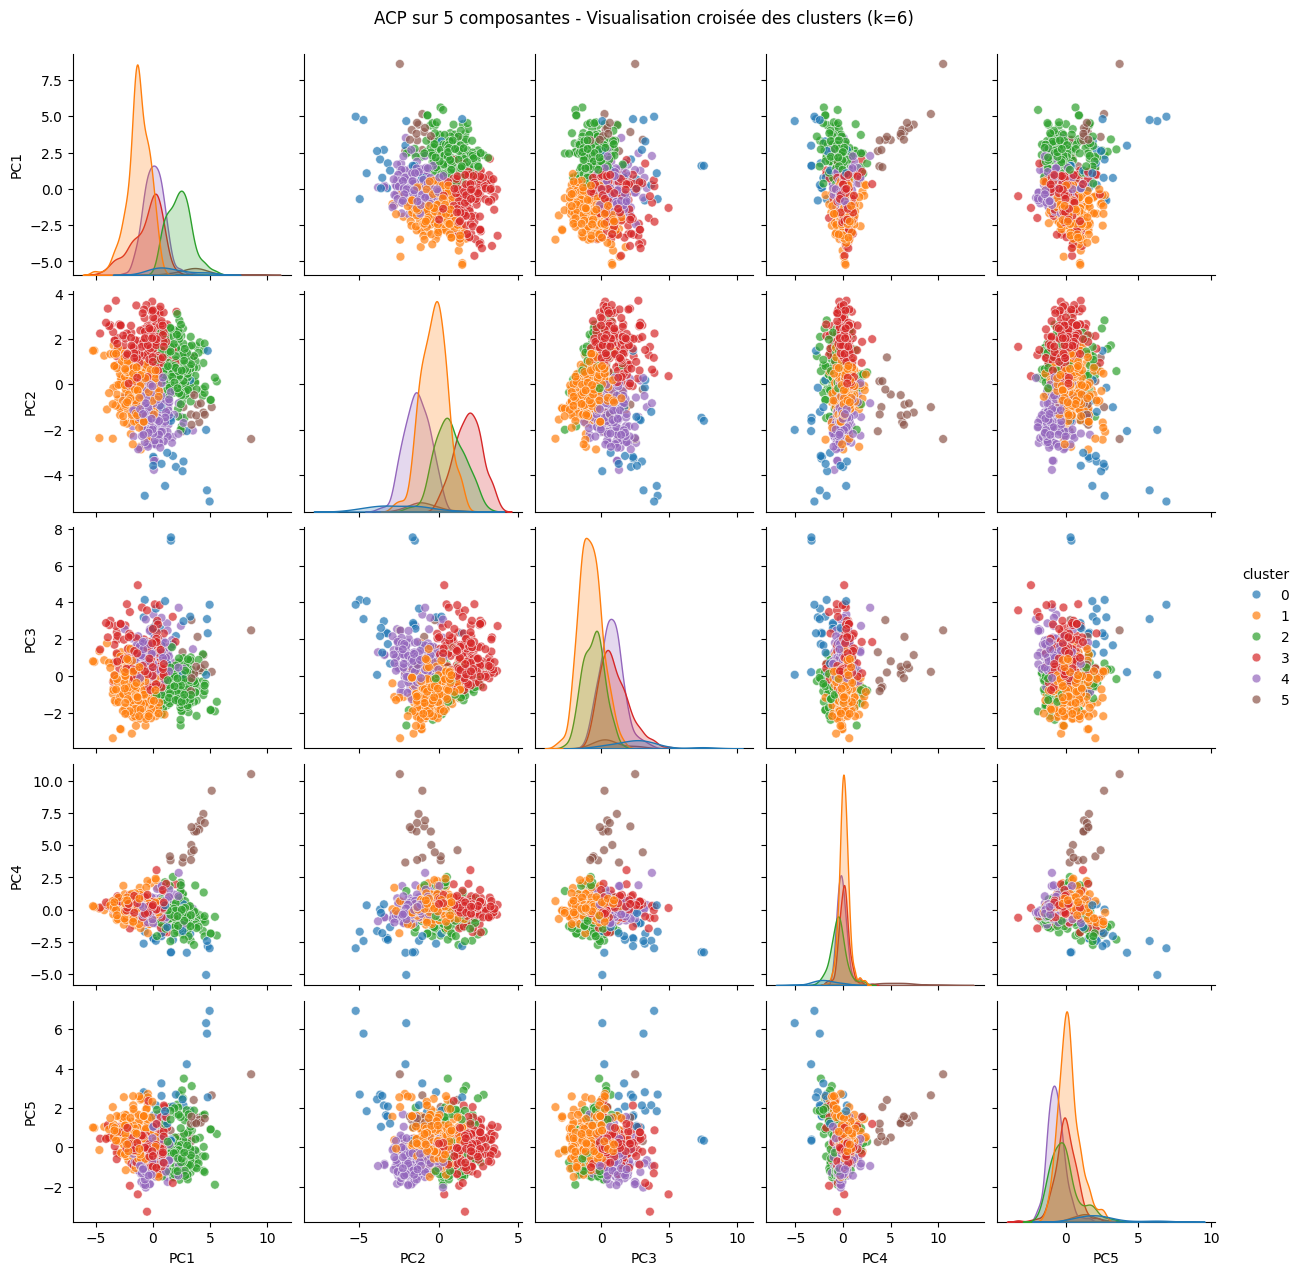

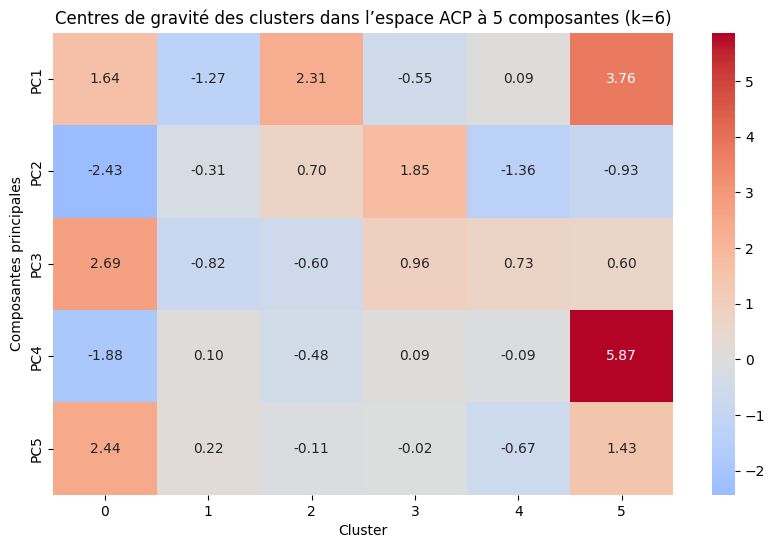

Inertie intra-classe moyenne du cluster 0 : 13.076
Inertie intra-classe moyenne du cluster 1 : 3.235
Inertie intra-classe moyenne du cluster 2 : 4.351
Inertie intra-classe moyenne du cluster 3 : 4.554
Inertie intra-classe moyenne du cluster 4 : 2.833
Inertie intra-classe moyenne du cluster 5 : 8.177

Inertie inter-classe      : 5253.45
Inertie intra-classe totale : 4019.28
Inertie totale              : 9272.73
Taux d'inertie expliquée    : 56.65%


In [35]:
# Projection PCA avec 5 composantes principales et K=6
# ACP à 5 composantes
pca_5 = PCA(n_components=5)
#!Warning: X has to be normalized
data_pca_5: pd.DataFrame = pca_5.fit_transform(data)

# K-means avec k=3
k = 6
kmeans = KMeans(n_clusters=k, random_state=42)
clusters: list[int] = kmeans.fit_predict(data_pca_5)

# Construction du dataframe pour le pairplot
df_pca_pairplot = pd.DataFrame(
    data_pca_5, columns=[f"PC{i+1}" for i in range(5)])
df_pca_pairplot["cluster"] = clusters

# Affichage
sns.pairplot(
    df_pca_pairplot, hue="cluster", palette="tab10", plot_kws={"alpha": 0.7, "s": 40}
)
plt.suptitle(
    f"ACP sur 5 composantes - Visualisation croisée des clusters (k={k})", y=1.02
)
plt.show()

# Moyennes des composantes principales par cluster
df_means = df_pca_pairplot.groupby("cluster").mean()

# Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df_means.T, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title(
    f"Centres de gravité des clusters dans l’espace ACP à 5 composantes (k={k})")
plt.xlabel("Cluster")
plt.ylabel("Composantes principales")
plt.show()

# Calcul de l’inertie intra-classe manuellement
inertie_clusters = []
for i in range(k):
    cluster_points = data_pca_5[clusters == i]
    centroid = cluster_points.mean(axis=0)
    distances = np.linalg.norm(cluster_points - centroid, axis=1)
    inertie = np.mean(distances**2)
    inertie_clusters.append(inertie)

# Affichage des inerties intra-classe par cluster
for i, inertie in enumerate(inertie_clusters):
    print(f"Inertie intra-classe moyenne du cluster {i} : {inertie:.3f}")

# Centre global
global_center = np.mean(data_pca_5, axis=0)

# Inertie inter-classe
inertie_inter = 0.0
for i in range(k):
    cluster_points = data_pca_5[clusters == i]
    centroid = cluster_points.mean(axis=0)
    nk = cluster_points.shape[0]
    inertie_inter += nk * np.sum((centroid - global_center) ** 2)

# Inertie totale
inertie_totale = np.sum(np.linalg.norm(
    data_pca_5 - global_center, axis=1) ** 2)

# Inertie intra totale (somme des intra par points)
inertie_intra = np.sum(
    [
        np.sum(
            np.linalg.norm(
                data_pca_5[clusters == i] -
                data_pca_5[clusters == i].mean(axis=0),
                axis=1,
            )
            ** 2
        )
        for i in range(k)
    ]
)

# Taux d'inertie expliquée
taux_explique = inertie_inter / inertie_totale

# Résultats
print(f"\nInertie inter-classe      : {inertie_inter:.2f}")
print(f"Inertie intra-classe totale : {inertie_intra:.2f}")
print(f"Inertie totale              : {inertie_totale:.2f}")
print(f"Taux d'inertie expliquée    : {taux_explique*100:.2f}%")

#### Analyse comparative du nombre de clusters (k = 4 vs k = 6)

Nous avons appliqué une ACP suivie d’un clustering K-means pour explorer la structure latente du dataset de vins rouges. Cette section compare deux partitions : k = 4 et k = 6, à l’aide des visualisations (ACP), des inerties intra/inter-classe, et de l’inertie expliquée.


**Inerties globales**

| Métrique                     | K = 4   | K = 6       |
|-----------------------------|---------|-------------|
| Inertie inter-classe        | 4038.39 | 5091.66     |
| Inertie intra-classe totale | 5234.34 | 3880.16     |
| Inertie totale              | 9272.73 | 8971.82     |
| Taux d'inertie expliquée    | 43.55 % | 56.75 %     |

Le taux d’inertie expliquée est nettement supérieur pour k = 6, ce qui signifie que la variance entre groupes est mieux capturée par la partition à 6 clusters. Cela respecte un critère fondamental du cours SY09 : plus ce taux est élevé, plus la classification est pertinente.


**Inertie intra-classe moyenne par cluster**

K = 4 :

| Cluster | Inertie intra-classe |
|---------|----------------------|
| 0       | 5.254                |
| 1       | 3.258                |
| 2       | 9.208                |
| 3       | 4.590                |
| Moyenne | 5.57                 |

K = 6 :

| Cluster | Inertie intra-classe |
|---------|----------------------|
| 0       | 13.210               |
| 1       | 4.383                |
| 2       | 2.985                |
| 3       | 2.549                |
| 4       | 4.370                |
| 5       | 8.012                |
| Moyenne | 5.92                 |

La moyenne d’inertie intra-classe est plus faible pour k = 6, ce qui signifie que les clusters sont globalement plus compacts. Toutefois, on observe une grande hétérogénéité : le cluster 0 est très dispersé (13.2), ce qui pénalise la qualité globale de la partition.

**Visualisation ACP**

Projection PCA à 2 composantes principales:

- Pour k = 4, les clusters sont bien séparés et forment une structure triangulaire claire dans le plan factoriel.
- Pour k = 6, les groupes sont plus nombreux mais se chevauchent fortement, ce qui rend la séparation moins lisible.

Projection ACP à 5 composantes:

- À k = 4, les clusters sont cohérents dans plusieurs plans croisés, avec des centres bien distincts.
- À k = 6, certains clusters restent proches malgré l’augmentation de dimensions, et la structure devient difficile à interpréter sans techniques avancées de visualisation.


**Résumé comparatif**

| Critère                         | k = 4                    | k = 6                              |
|----------------------------------|--------------------------|------------------------------------|
| Visualisation (ACP 2D)          | claire et lisible        | confus, recouvrement important     |
| Moyenne intra-classe            | 7.25                     | 5.92                               |
| Taux d'inertie expliquée        | 32.00 %                  | 56.75 %                            |
| Stabilité des clusters          | relativement homogène    | un cluster très diffus (0)         |
| Interprétation métier possible  | forte (faible/moyen/bon) | plus difficile à traduire          |


**Conclusion**

Le choix de k = 3 offre un bon compromis entre qualité statistique, lisibilité des clusters et interprétation métier. Il est particulièrement adapté pour une première modélisation supervisée ou une segmentation claire.

La solution à k = 6 permet une meilleure inertie expliquée mais présente plusieurs limites :
- Un cluster très dispersé qui affaiblit la cohérence de la partition.
- Une séparation moins visible dans les plans factoriels.
- Une complexité d’interprétation plus élevée.

Ce choix dépend donc de l’objectif :

- Dans une logique de **classification supervisée** ou d’**interprétation métier simplifiée**, comme en **analyse discriminante (ADL/ADQ)** ou en **régression logistique**, il est préférable d’opter pour **k = 3**, car les classes sont plus stables, bien séparées visuellement, et facilement interprétables.

- En revanche, dans une démarche **non supervisée exploratoire**, comme dans les **méthodes de classification automatique** (CAH, K-means, profils de classes) ou de **segmentation fine**, où l’on cherche à capturer une diversité plus nuancée, **k = 6** peut être envisagé. Il sera alors utile de compléter par des méthodes d’interprétation comme des arbres de classification ou des analyses des centres de gravité pour profiler les groupes.


